In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import clear_output, HTML, display

plt.rcParams['figure.figsize'] = 12,8

In [2]:
class Environment:
    COLOR_MAP = {
        ' ': (1.0, 1.0, 1.0, 0.5),
        'S': (0.0, 0.0, 1.0, 0.3),
        'A': (0.7, 1.0, 0.0, 1.0),
        'B': (1.0, 0.3, 0.0, 0.7),
        '*': (0.0, 0.0, 0.0, 1.0),
    }
    TIME_LIMIT = 100
    
    
    def __init__(self, rewards=None, maze=None, dizzy=0.20, agent_position=(2, 0)):
        if rewards == None:
            self.rewards = {
                'A' : +1.0,
                'B' : -1.0,
                ' ' : -0.04,
                '*' : -0.04
            }
        else:
            self.rewards= rewards
        if maze == None:
            self.maze = [
                [' ', ' ', ' ', 'A'],
                [' ', '*', ' ', 'B'],
                [' ', ' ', ' ', ' '],
            ]
        else:
            self.maze = maze
        self.maze_w = len(self.maze[0])
        self.maze_h = len(self.maze)
        self.dizzy = dizzy # prob. of change in direction
        self.time = 0
        self.initial_agent_position = agent_position
        self.agent_position = agent_position # start state
        self.status = 'ongoing'
        self.log = []
        
        
    def animate(self, delay=1):
        
        def __animate(time):
            
            def __calculate_arrow(d):
                if d == 'right':
                    dx = 0.4
                    dy = 0
                elif d == 'left':
                    dx = -0.4
                    dy = 0
                elif d == 'up':
                    dx = 0
                    dy = -0.4
                elif d == 'down':
                    dx = 0
                    dy = +0.4
                return dx, dy
            
            plt.clf()
            plt.xticks(np.arange(-0.5, self.maze_w, 1), labels=[])
            plt.yticks(np.arange(-0.5, self.maze_h, 1), labels=[])
            plt.grid()
            plt.title("$t={}$".format(time))
            if time == self.time:
                y, x = self.agent_position
                self.maze[y][x] = 'S'
                _ = plt.imshow([[self.COLOR_MAP[i] for i in j] for j in self.maze])
                self.maze[y][x] = ' '
                return _,
            desired_action, given_action, position = self.log[time]
            y, x = position
            self.maze[y][x] = 'S'
            plt.imshow([[self.COLOR_MAP[i] for i in j] for j in self.maze])
            self.maze[y][x] = ' '
            dx, dy = __calculate_arrow(desired_action)
            plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, color='b')
            dx, dy = __calculate_arrow(given_action)
            _ = plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, color='y')
            return _,
        
        anim = FuncAnimation(plt.figure(), __animate, frames=self.time+1, interval = delay * 1000)
        display(HTML(anim.to_html5_video()))
        plt.close()
        
        
    def __findNextState(self, state, action):
        y, x = state
        if self.maze[y][x] == 'A' or self.maze[y][x] == 'B':
            return state
        if action == 'left':
            if x > 0 and self.maze[y][x-1] != '*':
                x -= 1
        elif action == 'right':
            if x < self.maze_w - 1 and self.maze[y][x+1] != '*':
                x += 1
        elif action == 'up':
            if y > 0 and self.maze[y-1][x] != '*':
                y -= 1
        elif action == 'down':
            if y < self.maze_h - 1 and self.maze[y+1][x] != '*':
                y += 1
        return (y,x)
        
    
    def interact(self, action):
        if self.status == 'ongoing':
            if np.random.rand() < self.dizzy:
                if action == 'left':
                    newAction = 'down' if np.random.rand() < 0.50 else 'up'
                elif action == 'right':
                    newAction = 'up' if np.random.rand() < 0.50 else 'down'
                elif action == 'up':
                    newAction = 'left' if np.random.rand() < 0.50 else 'right'
                elif action == 'down':
                    newAction = 'right' if np.random.rand() < 0.50 else 'left'
                self.log.append((action, newAction, self.agent_position))
                action = newAction
            else:
                newAction = action
                self.log.append((action, newAction, self.agent_position))
            y, x = self.__findNextState(self.agent_position, action)
            self.agent_position = y, x # update position
            reward = self.rewards[self.maze[y][x]] # calculate r_t
            self.status = 'ongoing'
            if self.maze[y][x] == 'A' or self.maze[y][x] == 'B':
                self.status = 'done'
            self.time += 1 # increase time
            if self.time == self.TIME_LIMIT:
                self.status = 'done'
            return reward
        
    
    def info(self, state, action):
        y, x = state
        directions = {
            'left': ['left', 'up', 'down'],
            'right': ['right', 'up', 'down'],
            'up': ['up', 'left', 'right'],
            'down': ['down', 'left', 'right']
        }
        probs = [1-self.dizzy, self.dizzy/2, self.dizzy/2]
        results = []
        for direction in directions[action]:
            s = self.__findNextState(state, direction)
            r = self.rewards[self.maze[s[0]][s[1]]]
            d = self.maze[s[0]][s[1]] != ' '# or self.maze[s[0]][s[1]] == 'B' or self.maze
            p = probs[len(results)]
            results.append([p, s, r, d])
        return results
    
    
    def reset(self):
        self.time = 0
        self.agent_position = self.initial_agent_position
        self.status = 'ongoing'
        self.log = []

In [3]:
class Agent:
    ACTIONS = ['left', 'up', 'right', 'down']
    
    
    def __init__(self, environment=None, gamma=0.03):
        self.env = environment if environment != None else Environment()
        self.policy = None
        self.V = None
        self.score = 0.0
        self.gamma = gamma
        
        
    def display(self):
        plt.subplot(1,2,1)
        plt.xticks(np.arange(-0.5, self.env.maze_w, 1), labels=[])
        plt.yticks(np.arange(-0.5, self.env.maze_h, 1), labels=[])
        plt.grid()
        plt.title("State Values")
        y, x = self.env.agent_position
        self.env.maze[y][x] = 'S'
        _ = plt.imshow([[self.env.COLOR_MAP[i] for i in j] for j in self.env.maze])
        self.env.maze[y][x] = ' '
        for index, data in enumerate(self.V.flatten()):
            index = np.unravel_index(index, self.V.shape)
            plt.text(x=index[1], y=index[0], s="{:.2f}".format(data))
        plt.subplot(1,2,2)
        plt.xticks(np.arange(-0.5, self.env.maze_w, 1), labels=[])
        plt.yticks(np.arange(-0.5, self.env.maze_h, 1), labels=[])
        plt.grid()
        plt.title("Optimal Actions")
        y, x = self.env.agent_position
        self.env.maze[y][x] = 'S'
        plt.imshow([[self.env.COLOR_MAP[i] for i in j] for j in self.env.maze])
        self.env.maze[y][x] = ' '
        for state_id in range(self.env.maze_h * self.env.maze_w):
            y, x = np.unravel_index(state_id, self.V.shape)
            action = self.ACTIONS[self.policy[y,x]]
            if action == 'left':
                dx = -0.3
                dy = +0.0
            if action == 'right':
                dx = +0.3
                dy = +0.0
            if action == 'up':
                dx = +0.0
                dy = -0.3
            if action == 'down':
                dx = +0.0
                dy = +0.3
            plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, color='k')
        plt.show()
        
        
    def _policyEval(self):
        while True:
            old_V = self.V.copy()
            for state in range(self.env.maze_h * self.env.maze_w):
                state = np.unravel_index(state, self.V.shape)
                a = self.policy[state] # pick an action according to policy
                sigma = sum(p * self.V[ns] if not t else 0.0 for p, ns, r, t in self.env.info(state, self.ACTIONS[a]))
                reward = sum(p * r for p, ns, r, t in self.env.info(state, self.ACTIONS[a]))
                self.V[state] = (reward + self.gamma * sigma)
            if np.allclose(old_V, self.V):
                break
    
    
    def _policyImprove(self):
        for state in range(self.env.maze_h * self.env.maze_w):
            state = np.unravel_index(state, self.V.shape)
            action_values = np.zeros(len(self.ACTIONS))
            for a in range(len(self.ACTIONS)):
                action_values[a] = sum(p * self.V[ns] for p, ns, r, t in self.env.info(state, self.ACTIONS[a]))
            best_action = np.argmax(action_values)
            self.policy[state] = best_action

    
    def train(self):
        print("Training has begun...")
        self.policy = np.zeros( (self.env.maze_h, self.env.maze_w) , dtype=int)
        self.V = np.zeros( (self.env.maze_h, self.env.maze_w) )
        self.V[0,3] = 1
        self.V[1,3] = -1
        while True:
            old_policy = self.policy.copy()
            self._policyEval()
            self._policyImprove()
            if np.allclose(old_policy, self.policy):
                break
        print("Training finished.")

        
    def play(self):
        if self.policy is None:
            print('No policy trained!')
            return
        self.score = 0.0
        while self.env.status == 'ongoing':
            selected_action =  self.ACTIONS[self.policy[self.env.agent_position]]
            self.score += self.env.interact(selected_action)
        print("Score: {:.2f}".format(self.score))
        self.env.animate()
        self.env.reset()

Training has begun...
Training finished.


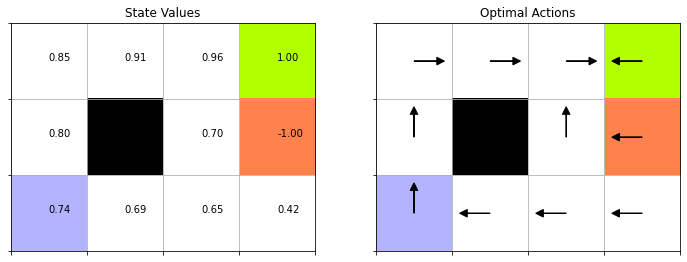

In [4]:
agent = Agent(
    Environment(agent_position=(0,0),
        maze=[[' ', '*', 'B', ' ', ' ', ' '],
                [' ', ' ', 'B', ' ', 'B', ' '],
                [' ', ' ', ' ', ' ', ' ', ' '],
                [' ', ' ', ' ', 'B', ' ', ' '],
                [' ', ' ', ' ', ' ', ' ', ' '],
                [' ', 'B', ' ', '*', ' ', ' '],
                [' ', ' ', ' ', '*', ' ', ' '],
                [' ', ' ', ' ', ' ', ' ', 'A']],
        rewards={'A' : +1.0,
            'B' : -1.0,
            ' ' : +0.1,
            '*' : +0.1}),
    gamma=0.99)
agent = Agent(gamma=0.999)
agent.train()
agent.display()

In [5]:
agent.play()

Score: 0.84


**Written by Berktug Kaan Ozkan.**